# Librerias

In [2]:
pip install yfinance


     |████████████████████████████████| 6.3 MB 10.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=2de6c4cd6af5fb6bad23640fceb901f98c2cd20159d7f022499d907cb2bc02d3
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import datetime as date

# Selección de datos

In [4]:
index=["TSLA","AAPL","GOOG","AMZN","MELI"]
timeAnalysis="2y"

# Creación de base de datos

In [5]:
df = pd.DataFrame()

for i in index:
    a=yf.Ticker(f"{i}")
    hist = a.history(period=timeAnalysis)
    df_temp = pd.DataFrame(hist)
    df[f"{i}"]=df_temp["Close"]


In [6]:
df.tail()

,TSLA,AAPL,GOOG,AMZN,MELI
Date,,,,,
2021-10-15,843.030029,144.839996,2833.500000,3409.020020,1563.089966
2021-10-18,870.109985,146.550003,2859.209961,3446.739990,1592.619995
2021-10-19,864.270020,148.759995,2876.439941,3444.149902,1591.260010
2021-10-20,865.799988,149.259995,2848.300049,3415.060059,1604.010010
2021-10-21,894.000000,149.479996,2855.610107,3435.010010,1583.939941


# Modelo de varianza minima

Generamos $dfr$ : Data Frame de rendimientos de cada activo financiero

In [7]:
dfr = pd.DataFrame()
for i in df.columns.values:
    dfr[f"{i}"] = df[f"{i}"] / df[f"{i}"].shift(1) - 1
dfr.cov()

,TSLA,AAPL,GOOG,AMZN,MELI
TSLA,0.002132,0.000500,0.000375,0.000400,0.000678
AAPL,0.000500,0.000544,0.000326,0.000310,0.000419
GOOG,0.000375,0.000326,0.000388,0.000253,0.000329
AMZN,0.000400,0.000310,0.000253,0.000394,0.000346
MELI,0.000678,0.000419,0.000329,0.000346,0.001045


el modelo consiste en el calculo de la varianza de una cartera de activos financieros donde no es factible operar en corto, es decir, que el $w$ "peso" de cada activo financiero en cartera debe ser estrictamente positivo. el valor que hará las veces de input sera el rendimiento que esperamos obtener, a partir de ello se calculara la combinacion de activos financieros que configuren la cartera de menor riesgo.

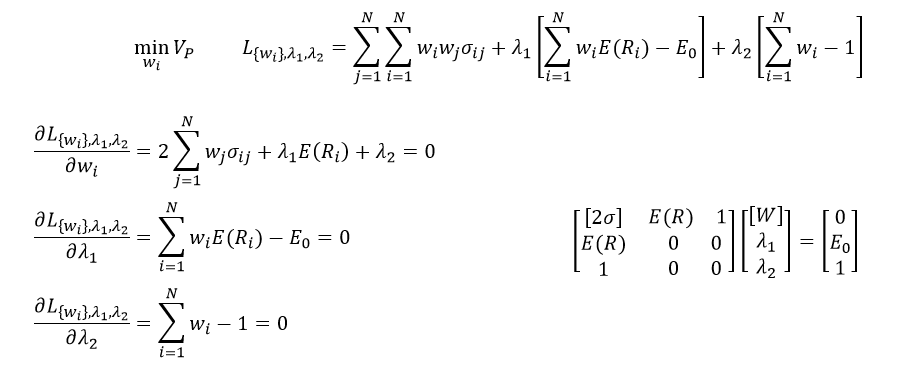

In [8]:
cov=dfr.cov()
cor=dfr.corr()
mean=dfr.mean()
print(cor)

          TSLA      AAPL      GOOG      AMZN      MELI
TSLA  1.000000  0.464252  0.412309  0.436478  0.454440
AAPL  0.464252  1.000000  0.709056  0.669045  0.555474
GOOG  0.412309  0.709056  1.000000  0.648087  0.516040
AMZN  0.436478  0.669045  0.648087  1.000000  0.538898
MELI  0.454440  0.555474  0.516040  0.538898  1.000000


In [9]:
def VM (R):
    vm_matrix=2*cov
    vm_matrix["E(R)"]=mean
    vm_matrix["w"]=1
    vm_matrix.loc[-2]=mean
    vm_matrix.loc[-1]=1
    vm_matrix["w"][-2]=0
    vm_matrix["w"][-1]=0
    vm_matrix['E(R)'][-2]=0
    vm_matrix['E(R)'][-1]=0
    vm_matrix.rename(index={-2:'E(R)',-1:'w'}, inplace=True)
    vm_matrix_inv = pd.DataFrame(np.linalg.inv(vm_matrix.values), vm_matrix.columns, vm_matrix.index)
    vm_matrix_inv["w*"]=vm_matrix_inv["E(R)"]*(((1+R)**(1/252)-1))+vm_matrix_inv["w"]
    weight=vm_matrix_inv["w*"][:-2]
    return weight

In [10]:
def IntVM():
    i=0.5
    E=[]
    Emaxmin=[]
    while i<2:
        if (VM(i).min() > 0):
            E.append(i)
        i=i+0.01
    Emaxmin.append(max(E))
    Emaxmin.append(min(E))
    print(Emaxmin) 



Rango de accionar de rendimientos: se espera que el rendidmiento que este dispuesto a obtener se encuentre dentro del intervalo generado por "$IntVM$"

Luego solo operamos la función "$VM$" para obtener la compocicion de cartera.

In [11]:
IntVM()

[1.750000000000001, 0.7400000000000002]


In [12]:
VM(1.5)

TSLA    0.363929
AAPL    0.065664
GOOG    0.472385
AMZN    0.075834
MELI    0.022188
Name: w*, dtype: float64